## Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import MNIST


## Trained CNN

In [3]:
transform = transforms.Compose([
    transforms.Lambda(lambda pic: torch.tensor(np.array(pic), dtype=torch.float32).unsqueeze(0))
])

# Load training and test datasets
train_dataset = MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = MNIST(root='./data', train=False, download=True, transform=transform)

# Create data loaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Training samples: {len(train_dataset)}")
print(f"Test samples: {len(test_dataset)}")

Training samples: 60000
Test samples: 10000


In [5]:
# Define a lightweight CNN architecture
class LightweightCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(LightweightCNN, self).__init__()

        # First convolutional block
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.pool1 = nn.MaxPool2d(2, 2)

        # Second convolutional block
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.pool2 = nn.MaxPool2d(2, 2)

        # Third convolutional block
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.pool3 = nn.MaxPool2d(2, 2)

        # Fully connected layers
        self.fc1 = nn.Linear(64 * 3 * 3, 128)  # 28x28 -> 14x14 -> 7x7 -> 3x3 after pooling
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))
        x = self.pool3(F.relu(self.bn3(self.conv3(x))))
        # Flatten and fully connected layers
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        
        return x


In [6]:
def init_weights(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        nn.init.normal_(m.weight, mean=0.0, std=0.01)  # smaller std for large inputs
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)

In [7]:
# Initialize the model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = LightweightCNN(num_classes=10).to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)

print(f"Model created on device: {device}")
print(f"Total parameters: {sum(p.numel() for p in model.parameters()):,}")


Model created on device: cpu
Total parameters: 98,666


In [8]:
# Training function
def train_model(model, train_loader, criterion, optimizer, device, epochs=5):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        correct = 0
        total = 0

        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)

            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = output.max(1)
            total += target.size(0)
            correct += predicted.eq(target).sum().item()

            if batch_idx % 200 == 0:
                print(f'Epoch {epoch + 1}/{epochs}, Batch {batch_idx}/{len(train_loader)}, '
                      f'Loss: {loss.item():.4f}, Accuracy: {100. * correct / total:.2f}%')

        epoch_loss = running_loss / len(train_loader)
        epoch_acc = 100. * correct / total
        print(f'Epoch {epoch + 1} completed - Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%')
        print('-' * 50)


# Train the model
print("Starting training...")
train_model(model, train_loader, criterion, optimizer, device, epochs=3)


Starting training...
Epoch 1/3, Batch 0/938, Loss: 2.3323, Accuracy: 14.06%
Epoch 1/3, Batch 200/938, Loss: 0.2656, Accuracy: 81.48%
Epoch 1/3, Batch 400/938, Loss: 0.1555, Accuracy: 88.23%
Epoch 1/3, Batch 600/938, Loss: 0.1753, Accuracy: 91.06%
Epoch 1/3, Batch 800/938, Loss: 0.0596, Accuracy: 92.46%
Epoch 1 completed - Loss: 0.2416, Accuracy: 93.14%
--------------------------------------------------
Epoch 2/3, Batch 0/938, Loss: 0.0793, Accuracy: 96.88%
Epoch 2/3, Batch 200/938, Loss: 0.1064, Accuracy: 97.81%
Epoch 2/3, Batch 400/938, Loss: 0.0315, Accuracy: 97.78%
Epoch 2/3, Batch 600/938, Loss: 0.0648, Accuracy: 97.83%
Epoch 2/3, Batch 800/938, Loss: 0.0938, Accuracy: 97.95%
Epoch 2 completed - Loss: 0.0698, Accuracy: 97.97%
--------------------------------------------------
Epoch 3/3, Batch 0/938, Loss: 0.0205, Accuracy: 100.00%
Epoch 3/3, Batch 200/938, Loss: 0.1720, Accuracy: 98.41%
Epoch 3/3, Batch 400/938, Loss: 0.0065, Accuracy: 98.40%
Epoch 3/3, Batch 600/938, Loss: 0.0153,

In [9]:
# Test the model
def test_model(model, test_loader, device):
    model.eval()
    test_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()
            _, predicted = output.max(1)
            total += target.size(0)
            correct += predicted.eq(target).sum().item()

    test_loss /= len(test_loader)
    accuracy = 100. * correct / total

    print(f'Test Loss: {test_loss:.4f}')
    print(f'Test Accuracy: {accuracy:.2f}%')

    return accuracy


# Evaluate the trained model
print("Evaluating model on test set...")
test_accuracy = test_model(model, test_loader, device)


Evaluating model on test set...
Test Loss: 0.0305
Test Accuracy: 99.00%


Visualizing some predictions...
Pixel values of the first image:
[[  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0

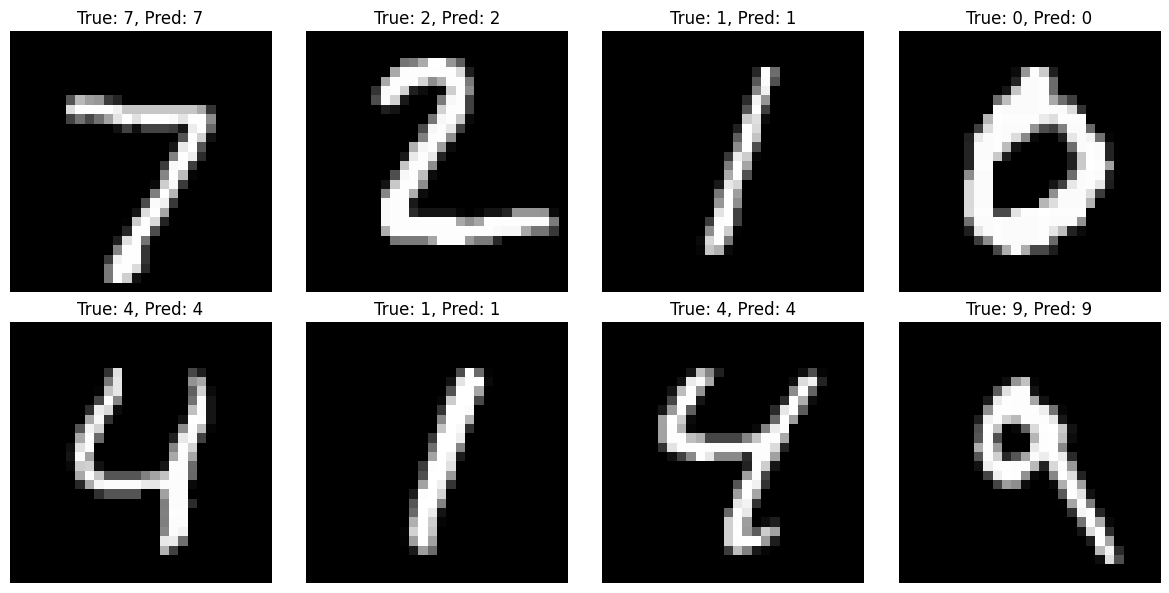

In [10]:
# Visualize some predictions
def visualize_predictions(model, test_loader, device, num_samples=8):
    model.eval()
    with torch.no_grad():
        # Get a batch of test data
        data_iter = iter(test_loader)
        images, labels = next(data_iter)
        images, labels = images.to(device), labels.to(device)

        # Get predictions
        outputs = model(images)
        _, predicted = outputs.max(1)

        # Move back to CPU for visualization
        images = images.cpu()
        labels = labels.cpu()
        predicted = predicted.cpu()

        img = images[0]

        img_np = img.squeeze().numpy()  # remove channel dimension

        print("Pixel values of the first image:")
        print(img_np)

        print(f"Min value: {img_np.min()}, Max value: {img_np.max()}")

        # Create subplot
        fig, axes = plt.subplots(2, 4, figsize=(12, 6))
        axes = axes.ravel()

        for i in range(num_samples):
            axes[i].imshow(images[i].squeeze(), cmap='gray')
            axes[i].set_title(f'True: {labels[i].item()}, Pred: {predicted[i].item()}')
            axes[i].axis('off')

        plt.tight_layout()
        plt.show()


# Visualize predictions
print("Visualizing some predictions...")
visualize_predictions(model, test_loader, device)


## IPFE-enhanced CNN

In [11]:
# import ipfe functions
from altered_ipfe import IPFE

### current try

In the First layer we applied 16 filters of size 3x3, with input channel 1 (grayscale), so the total number of parameters is 16 * 3 * 3 * 1 = 144.

So With that each y is one filter flattened to a vector of length 9.
For an input x of size 28x28, flattened to a vector of length 784, we can compute the inner product <x, y> for each filter y.

Option 1 encrypt the entire input x of length 784, and padd the y to a length of 784 with zeros. -> This will be inefficient as the IPFE scheme will have to handle large vectors.

Option 2 encrypt patches of x corresponding to the filter size (3x3 = 9 elements), and compute the inner product for each patch with the filter y. This requires sliding the filter over the input image and encrypting each patch separately.

1. Step: Create patches of size 3x3 from the input image (28x28) -> This will create 28x28 patches (with padding). => 784 patches
2. Step: Encrypt each patch separately.
3. Step: Create 16 query vectors y (one for each filter), each of size 9 (3x3 flattened). => Create a Key for each vector
4. Step: decrypt each inner product result to get the convolution output.

In [67]:
class IPFECNN(nn.Module):
    def __init__(self, num_classes=10, prime=1000000007):
        super(IPFECNN, self).__init__()
        self.prime = prime
        self.ipfe = IPFE(prime)
        self.encryption_length = 9 # 3x3 filter size flattened

        self.ipfe.setup(self.encryption_length)
        print("IPFE setup done, with length:", self.encryption_length)

        # First convolutional block - this will be used with IPFE
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.pool1 = nn.MaxPool2d(2, 2)

        # Second convolutional block
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.pool2 = nn.MaxPool2d(2, 2)

        # Third convolutional block
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.pool3 = nn.MaxPool2d(2, 2)

        # Fully connected layers
        self.fc1 = nn.Linear(64 * 3 * 3, 128)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, num_classes)

        #copy weights from the trained model
        self.load_state_dict(model.state_dict())
        print("weights copied from trained model")

        self.weights = self.conv1.weight.data
        self.y_array = torch.round(self.weights.view(self.weights.size(0), -1).squeeze(1).view(self.weights.size(0), -1) * 10000).long().tolist()
        print("weights converted to y vectors")
        self.biases = self.conv1.bias
        print("biases saved")
        self.sk_y_array = [self.ipfe.key_derive(y) for y in self.y_array]
        print("sk_ys created")

    def encrypt_data(self, test_set):
        unfold = nn.Unfold(kernel_size=3, stride=1, padding=1)
        patches = unfold(test_set)
        B, patch_size, num_patches = patches.shape

        encrypted_patches = []

        for b in range(B):
            patches_b = patches[b].T  # (H*W, patch_size)
            encrypted_image = []
            for p in range(num_patches):
                patch = patches_b[p]
                patch_int = [(int(val.item()) % (self.prime - 1)) for val in patch]
                encrypted = self.ipfe.encrypt(patch_int)  # could be tuple
                encrypted_image.append(encrypted)
            encrypted_patches.append(encrypted_image)

        return encrypted_patches


    def first_conv_forward(self, x, H, W):
        num_patches = len(x)
        num_kernels = len(self.sk_y_array)
        device = next(self.parameters()).device

        feature_maps_batch = []

        decrypted_maps = torch.zeros(num_kernels, num_patches, device=device)

        for k in range(num_kernels):
            for p in range(num_patches):
                decrypted_scaled = self.ipfe.decrypt(
                    x[p],
                    self.sk_y_array[k],
                    self.y_array[k],
                )
                decrypted = (decrypted_scaled / 10000) + self.biases[k].item()
                decrypted_maps[k, p] = decrypted

        return torch.stack([decrypted_maps.view(num_kernels, H, W)], dim=0)


    def forward(self, x, H, W, encrypted=False):
        if encrypted:
            outputs = []
            for sample in x:  # x = [ [patches_img1], [patches_img2], ... ]
                feat = self.first_conv_forward(sample, H, W)
                feat = self.pool1(F.relu(self.bn1(feat)))
                feat = self.pool2(F.relu(self.bn2(self.conv2(feat))))
                feat = self.pool3(F.relu(self.bn3(self.conv3(feat))))
                feat = feat.view(feat.size(0), -1)
                feat = F.relu(self.fc1(feat))
                feat = self.dropout(feat)
                feat = self.fc2(feat)
                outputs.append(feat)
            return torch.cat(outputs, dim=0)
        else:
            x = self.conv1(x)
            x = self.pool1(F.relu(self.bn1(x)))
            x = self.pool2(F.relu(self.bn2(self.conv2(x))))
            x = self.pool3(F.relu(self.bn3(self.conv3(x))))
            x = x.view(x.size(0), -1)
            x = F.relu(self.fc1(x))
            x = self.dropout(x)
            x = self.fc2(x)
            return x



In [68]:
# Initialize IPFE-enhanced CNN
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
ipfe_model = IPFECNN(num_classes=10, prime=1000000007).to(device)

print(f"IPFE-CNN model created on device: {device}")

IPFE setup done, with length: 9
weights copied from trained model
weights converted to y vectors
biases saved
sk_ys created
IPFE-CNN model created on device: cpu


In [69]:
def encrypt_test_data(model, test_loader, device, num_samples=5):
    """Encrypt a batch of test data"""
    model.eval()
    with torch.no_grad():

        # Get a batch of test data
        data_iter = iter(test_loader)
        images, labels = next(data_iter)
        images, labels = images.to(device), labels.to(device)

        # Encrypt only a subset
        images_subset = images[:num_samples]
        labels_subset = labels[:num_samples]

        # Encrypt the data
        encrypted_data = model.encrypt_data(images_subset)
        print(f"Encrypted {num_samples} samples.")

        H, W = images.size(2), images.size(3)

    return encrypted_data, labels_subset, H, W

In [70]:
encrypted_data, labels, H, W = encrypt_test_data(ipfe_model, test_loader, device, num_samples=2)

Encrypted 2 samples.


In [71]:
len(encrypted_data)

2

In [74]:
# Test IPFE functionality with a sample
def test_ipfe_cnn(model, encrypted_data, labels, H, W, device):
    """Test the IPFE-CNN with a sample query vector"""
    model.eval()

    with torch.no_grad():
        print("Testing IPFE-CNN forward pass on encrypted data...")
        print(f"Labels of test samples: {labels.cpu().numpy()}")

        try:
            outputs = model.forward(encrypted_data, encrypted=True, H=H, W=W)
            _, predicted = outputs.max(1)

            print(f"Predictions on encrypted data: {predicted.cpu().numpy()}")

            correct = (predicted == labels).sum().item()
            total = labels.size(0)
            print(f"Accuracy on encrypted samples: {100 * correct / total:.2f}% ({correct}/{total})")


        except Exception as e:
            print(f"Encrypted IPFE forward pass failed: {e}")


In [75]:
print("Testing IPFE-CNN functionality...")
test_ipfe_cnn(ipfe_model, encrypted_data, labels, H, W, device)


Testing IPFE-CNN functionality...
Testing IPFE-CNN forward pass on encrypted data...
Labels of test samples: [7 2]
Predictions on encrypted data: [7 2]
Accuracy on encrypted samples: 100.00% (2/2)
